**# Data cleaning**

In [28]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# 1. UNIVERSAL PATHING
# Adjust 'project_dataset' to your local folder name if different
data_folder = "project_dataset"
cash_path = os.path.join(data_folder, "extract - cash request - data analyst.csv")
fees_path = os.path.join(data_folder, "extract - fees - data analyst - .csv")

# 2. LOADING DATA
cash_request = pd.read_csv(cash_path)
fees = pd.read_csv(fees_path)

# 3. DATE CLEANING (Merged logic)
# Combining all date columns identified by the team
cash_date_cols = ["created_at", "updated_at", "moderated_at", "reimbursement_date", 
                  "cash_request_received_date", "money_back_date", "send_at", 
                  "reco_creation", "reco_last_update"]

fees_date_cols = ["created_at", "updated_at", "paid_at", "from_date", "to_date"]

# Apply conversion to cash_request
for col in cash_date_cols:
    if col in cash_request.columns:
        cash_request[col] = pd.to_datetime(cash_request[col], errors='coerce')

# Apply conversion to fees
for col in fees_date_cols:
    if col in fees.columns:
        fees[col] = pd.to_datetime(fees[col], errors='coerce')

# 4. DATA INTEGRITY FIXES
# Ensure IDs are integers for proper merging later
fees["cash_request_id"] = fees["cash_request_id"].astype("Int64")
cash_request["user_id"] = cash_request["user_id"].astype("Int64")

print("✅ System Ready: Data loaded, dates converted, and IDs formatted.")



✅ System Ready: Data loaded, dates converted, and IDs formatted.


0
0
These columns were dropped: []


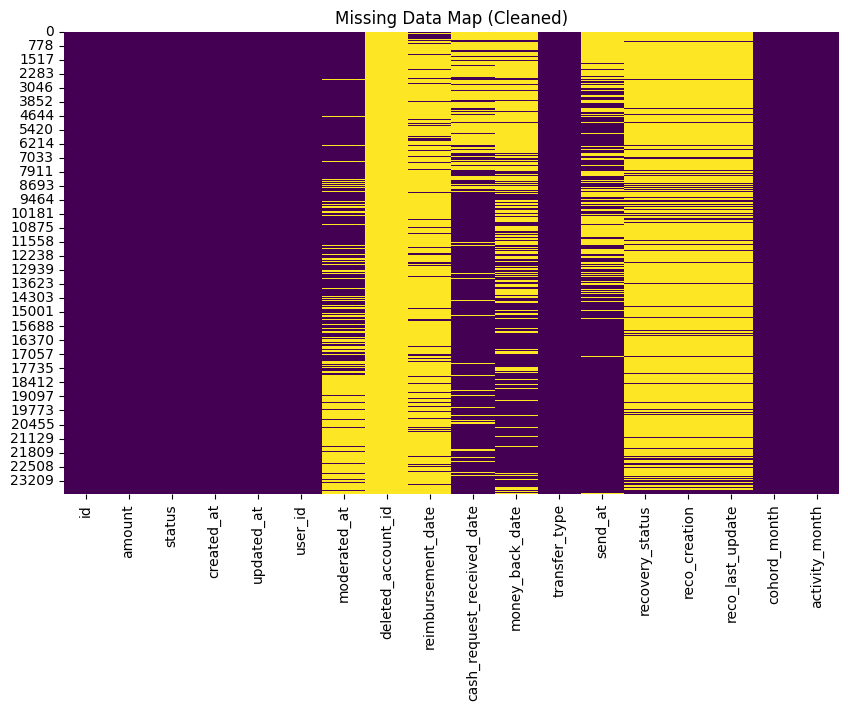

In [34]:
#Identify and drop completely emppty columns
cash_request = cash_request.dropna(subset=["created_at"])
print(cash_request["created_at"].isna().sum())
cash_request = cash_request.dropna(subset=["user_id"])
print(cash_request["user_id"].isna().sum())
empty_cols = cash_request.columns[cash_request.isnull().all()]
cash_request = cash_request.drop(columns=empty_cols)

print(f"These columns were dropped: {list(empty_cols)}")

#Take a look at the remaining missing data 
plt.figure(figsize=(10, 6))
sns.heatmap(cash_request.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Map (Cleaned)')
plt.show()



In [19]:
#Make sure created_at is in datime format
cash_request['created_at'] =pd.to_datetime(cash_request['created_at'], errors = 'coerce')

#first advance month for each user

cash_request['cohort_month'] = cash_request.groupby('user_id')['created_at'].transform('min').dt.to_period('M')

#month of transaction
cash_request['transaction_month']= cash_request['created_at'].dt.to_period('M')

print("Cohorts, just the first 5 rows:")
print(cash_request[['user_id', 'created_at', 'cohort_month', 'transaction_month']].head())

Cohorts, just the first 5 rows:
   user_id                       created_at cohort_month transaction_month
0      804 2019-12-10 19:05:21.596873+00:00      2019-12           2019-12
1      231 2019-12-10 19:50:12.347780+00:00      2019-12           2019-12
2      191 2019-12-10 19:13:35.825460+00:00      2019-12           2019-12
3      761 2019-12-10 19:16:10.880172+00:00      2019-12           2019-12
4     7686 2020-05-06 09:59:38.877376+00:00      2020-05           2020-05


C:\Users\swapr\AppData\Local\Temp\ipykernel_26140\2669086850.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_request['cohort_month'] = cash_request.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
C:\Users\swapr\AppData\Local\Temp\ipykernel_26140\2669086850.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_request['transaction_month']= cash_request['created_at'].dt.to_period('M')


In [21]:
#How many unique cohorts?
unique_cohorts = cash_request['cohort_month'].unique()

# sort them by time
unique_cohorts = sorted(unique_cohorts)

print(f'There are {len(unique_cohorts)} unique cohorts.')
print('Cohort list:')
for cohort in unique_cohorts:
    print(f'-{cohort}')

There are 14 unique cohorts.
Cohort list:
-2019-11
-2019-12
-2020-05
-2020-06
-NaT
-2020-01
-2020-02
-2020-03
-2020-04
-2020-07
-2020-08
-2020-09
-2020-10
-2020-11


In [6]:
##What is this NaT, not a time? Maybe we missed something when cleaning?

In [7]:
Project Status & Next Steps
Current Progress:

Initial data cleaning is complete; completely empty columns have been dropped.

Date columns have been converted to datetime objects.

Preliminary cohorts have been defined using the first created_at month per user.

Note: We have 14 unique cohorts, including a NaT group that needs investigation for data quality reporting.

Next Steps for the Team:

Revenue Integration: Merge the fees data into the cash_request_cleaned dataframe. We need to group fees by cash_request_id and sum the total_amount first to avoid duplicating rows during the merge.

Incident Rate Calculation: Identify "incidents" within the fees table (look for type == 'incident' or specific status flags) to calculate the Incident Rate per cohort.

Retention/Frequency Matrix: Create a pivot table showing the number of active users in each cohort over the subsequent months to calculate the Frequency of Service Usage.

Data Quality Report: Document why we have NaT values and how many users are affected to fulfill the Data Quality Analysis requirement.

SyntaxError: invalid syntax (2676748378.py, line 1)

In [35]:
#Create cohorts
#cohord_month is the first month of request per user
cash_request["cohord_month"] = (cash_request.groupby("user_id")["created_at"].transform(min).dt.to_period("M"))


#Activity month(month of each request)
cash_request["activity_month"] = cash_request["created_at"].dt.to_period("M")


#Cohord index(months since first request)
cash_request["cohord_index"] = (cash_request["activity_month"] - cash_request["cohord_month"]).apply(lambda x: x.n)





C:\Users\swapr\AppData\Local\Temp\ipykernel_26140\3508180500.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_request["cohord_month"] = (cash_request.groupby("user_id")["created_at"].transform(min).dt.to_period("M"))
C:\Users\swapr\AppData\Local\Temp\ipykernel_26140\3508180500.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_request["activity_month"] = cash_request["created_at"].dt.to_period("M")


In [ ]:
#Frequency of service usage

#count of cash request per month
usage = (cash_request.groupby(["cohord_month", "cohord_index"]).size().reset_index(name="num_requests"))
print(usage)
#Pivot table:rows = cohort, columns = cohord_index, values = number of request
freq_pivot = cash_request.pivot_table(index="cohord_month", columns="cohord_index", values="id", aggfunc="count")

#Reset index for a table view
freq_table = freq_pivot.reset_index()
#freq_table


   cohord_month  cohord_index  num_requests
0       2019-11             0             1
1       2019-11             1             1
2       2019-11             5             1
3       2019-11             6             1
4       2019-11             9             1
..          ...           ...           ...
78      2020-09             1           707
79      2020-09             2            20
80      2020-10             0          4928
81      2020-10             1            15
82      2020-11             0            75

[83 rows x 3 columns]


cohord_index,cohord_month,0,1,2,3,4,5,6,7,8,9,10,11
0,2019-11,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,2.0
1,2019-12,229.0,75.0,46.0,66.0,66.0,74.0,76.0,63.0,76.0,50.0,71.0,1.0
2,2020-01,101.0,21.0,15.0,35.0,27.0,25.0,28.0,22.0,22.0,24.0,1.0,NaN
3,2020-02,90.0,48.0,48.0,44.0,42.0,37.0,45.0,27.0,42.0,NaN,NaN,NaN
4,2020-03,78.0,39.0,41.0,43.0,34.0,30.0,27.0,30.0,1.0,NaN,NaN,NaN
5,2020-04,229.0,131.0,133.0,97.0,99.0,78.0,73.0,NaN,NaN,NaN,NaN,NaN
6,2020-05,409.0,274.0,238.0,204.0,156.0,165.0,3.0,NaN,NaN,NaN,NaN,NaN
7,2020-06,1658.0,926.0,863.0,638.0,622.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-07,1736.0,856.0,566.0,570.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-08,894.0,328.0,278.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Average request per user
users_per_cohord = cash_request.groupby("cohord_month")["user_id"].nunique()
usage["avg_request_per_user"] = usage.apply(lambda row: row["num_requests"]/users_per_cohord[row["cohord_month"]], axis=1)